# The variance of the ROC AUC

---

## Recap: the probabilistic interpretation of the ROC AUC

Let $(X,Y)$ be jointly distributed with $Y$ taking values in $\{0,1\}$. This is the standard binary classification problem.

The ROC AUC measures the likelihood that a point in class 1 is scored higher than a point in class 0:

$$\boxed{A := \mathbb P(f(X) \geq f(X') | Y=1, Y'=0).}$$

If we write $P = \; f(X)|Y=1$ and $Q = \, f(X)|Y=0$, then one also sees 

$$A = \mathbb P(P \geq Q)$$


### The Mann-Whitney-Wilcoxon estimator

This can be estimated via the Mann–Whitney–Wilcoxon statistic

$$\boxed{\hat A = \frac{1}{n_0 n_1} \sum_{i=1}^{n_1} \sum_{j=1}^{n_0} 1_{P_i \geq Q_j}}$$

where $P_i$ refers to the score of a point in class 1, and $Q_j$ of one in class 0: 

$$P_i \equiv f(X_i)|Y_i=1,\qquad Q_j \equiv f(X_j)|Y_j=0$$

via the fact that $\mathbb E[\hat A] = A$.


### Example (to show that this is true)

In [18]:
import numpy as np
from sklearn.datasets import make_classification
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression

In [19]:
X, y = make_classification(2000, n_features=20, class_sep=0.6, 
                           weights=(0.8,),
                           random_state=2)

In [20]:
model = LogisticRegression().fit(X, y)

In [21]:
# As an area
y_probs = model.predict_proba(X)[:,1]
auc_area = roc_auc_score(y, y_probs)

In [22]:
# As a probability
n0, n1 = np.bincount(y)
total_sum = 0
for pi in y_probs[y==1]:
    for pj in y_probs[y==0]:
        if pi >= pj:
            total_sum += 1
auc_estimator = total_sum/(n0*n1)

In [23]:
print("ROC AUC calculated as an area:", round(auc_area,5))
print("ROC AUC calculated a statistic:", round(auc_estimator,5))

ROC AUC calculated as an area: 0.93089
ROC AUC calculated a statistic: 0.93089


Notice how both results are identical.

### Statistics of the ROC AUC

It is easily seen that $\mathbb E[\hat A] = A$, and thus one might ask what is the variance of this estimator. We will prove the following result (eq. (2) of [1] and eq. (6) of [2]):

**Theorem**. Under tha hypothesis that all points in a given class are independent (ie. $P$'s are iid among themselves, as are the $Q$') then the variance of the Mann-Whitney-Wilcoxon statistic is

$$\boxed{\mathrm{Var}\; \hat A = \frac{A(1-A) + (n_0 - 1)(P_{XYY} - A^2) + (n_1 - 1)(P_{XXY} - A^2)}{n_0 n_1},}$$

where 

$$P_{XXY} = \mathbb P (P \geq Q, P' \geq Q)$$

for any $P, P'$, and similarly 

$$P_{XYY} = \mathbb P(P \geq Q, P \geq Q')$$

for any $Q, Q'$.

### Proof:

In what follows, $1_{ij} \equiv 1_{P_i \geq Q_j}$ will be a shorthand notation.

By definition,

\begin{align*}
\mathrm{Var}\, (n_0 n_1 \hat A) &= \mathrm{Var}\, \left( \sum_{ij} 1_{ij} \right)\\
&= \sum_{ij} \sum_{kl} \mathrm{cov}\,(1_{ij}, 1_{kl})\\
&= \sum_{ij} \sum_{kl} \mathrm{cov}\,(1_{ij}, 1_{kl}) \left[ 1_{i=k\\ j= l} + 1_{i=k\\ j \neq l}+ 1_{i\neq k\\ j= l}+ 1_{i\neq k\\ j \neq l} \right]\\
&= \sum_{ij} \mathrm{Var} (1_{ij}) + \sum_i \sum_{j\neq l} \mathrm{cov}\,(1_{ij}, 1_{il}) + \sum_j \sum_{i\neq k} \mathrm{cov}\,(1_{ij}, 1_{kj}) + \sum_{i\neq k} \sum_{j\neq l} \mathrm{cov}\,(1_{ij}, 1_{kl})
\end{align*}

Now, we can simplify a bit by noting that 

\begin{align*}
\mathrm{cov}\,(1_{ij}, 1_{kl}) &\equiv \mathbb E[1_{ij} 1_{kl}] - \mathbb E[1_{ij}] \mathbb E[1_{kl}]\\
&= \mathbb E[1_{ij, kl}] - A^2
\end{align*}


where $1_{ij, kl}$ denotes $1_{P_i\geq Q_j, P_k \geq Q_l}$ and we see the AUC $A$ appear since $\mathbb E[1_{ij}] = \mathbb E[1_{P_i \geq Q_j}] = \mathbb P(P_i \geq Q_j) = A$.

Hence,

\begin{align*}
n_0^2 n_1^2 \mathrm{Var}\, \hat A =  \sum_{ij} \mathrm{Var} (1_{ij}) +
    \sum_i \sum_{j\neq l} \left( \mathbb E[1_{ij, il}] - A^2 \right) +
    \sum_j \sum_{i\neq k} \left( \mathbb E[1_{ij, kj}] - A^2 \right) + 
    \sum_{i \neq k} \sum_{j\neq l} \left( \mathbb E[1_{ij, kl}] - A^2 \right)
\end{align*}

Now, the summand in the last term is (explicitly) $\mathbb E[1_{P_i \geq Q_j, P_k \geq Q_l}]$. But since $i\neq k$ and $j \neq l$, the events $P_i \geq Q_j$ is completely independent from $P_k \geq Q_l$, and we can split the expectation into $\mathbb E[1_{P_i \geq Q_j}] \mathbb E[1_{P_k \geq Q_l}] = A^2$, which cancels the other $A^2$ term. 

Furthermore, it is easy to see that the term $\mathbb E[1_{ij, il}]$ is exactly the $P_{XYY}$ term defined above: it is the probability that a single score in class 1 ($P_i$) is greater than two random scores from class 0 ($Q_j$ and $Q_l$). An analogous reasoning shows that $\mathbb E[1_{ij, jk}] = \mathbb P_{XXY}$.

Putting these together, we are left with

\begin{align*}
 \mathrm{Var}\, \hat A =  \frac{1}{n_0^2 n_1^2} \left[
 \sum_{ij} \mathrm{Var} (1_{ij}) +
    \sum_i \sum_{j\neq l} \left( P_{XYY} - A^2 \right) +
    \sum_j \sum_{i\neq k} \left( P_{XXY} - A^2 \right)
 \right] \qquad (*)
\end{align*}

To go further, we need an intermediate result:

**Lemma 1**: $\boxed{\mathrm{Var}\, 1_{P\geq Q} = A(1-A)}$

*Proof*: we will need the expression for conditional variance: if $X, Y$ are random variables,

$$\mathrm{Var}\, X = \mathbb E[\mathrm{Var}\,(X|Y)] + \mathrm{Var}\,(\mathbb E[X|Y])$$

For any $P$ and $Q$, it then follows that

$$\mathrm{Var}\, 1_{P \geq Q} = \mathbb E[\mathrm{Var}\,(1_{P \geq Q}|Q)] + \mathrm{Var}\,(\mathbb E[1_{P\geq Q}|Q])$$

Now, it is not too hard to see how the variable $1_{P\geq Q}|Q$ is distributed. Since it takes values on $\{0,1\}$ is is in the Bernoulli familly; recall that $X \sim \mathrm{Bernoulli}(p)$ means that $\mathbb P(X=1) = 1-\mathbb P(X=0) = p$. In our case,

\begin{align*}
\mathbb P(1_{P\geq Q} = 1|Q) &= \mathbb P(P \geq Q|Q)\\
&= 1 - \mathbb P(P \leq Q|Q)\\
&\equiv 1 - F_P(Q)
\end{align*}

where $F_P$ is the CDF of $P$. Hence, 

$$1_{P\geq Q}|Q \,\sim\,\mathrm{Bernoulli}(1 - F_P(Q))$$

Now, a $\mathrm{Bernoulli}(p)$ variable has expectation $p$ and variance $p(1-p)$. It follows that

$$\mathbb E[1_{P\geq Q}|Q] = 1 - F_P(Q),\qquad \mathrm{Var}\, (1_{P\geq Q}|Q) = F_P(Q) (1 - F_P(Q))$$

and plugging these into the original expression for the variance we get

\begin{align*}
\mathrm{Var}\, 1_{P \geq Q} &= \mathbb E[\mathrm{Var}\,(1_{P \geq Q}|Q)] + \mathrm{Var}\,(\mathbb E[1_{P\geq Q}|Q])\\
&= \mathbb E[F_P(Q) (1 - F_P(Q))] + \mathrm{Var}\,(1 - F_P(Q))\\
&= \mathbb E[F_P(Q)] - \mathbb E[F_P^2(Q)] + \mathrm{Var}\,(F_P(Q));\qquad \mbox{ but } \mathrm{Var}\, X = \mathbb E[X^2] - \mathbb E[X]^2\\
&= \mathbb E[F_P(Q)] - \mathbb E[F_P^2(Q)] + \mathbb E[F_P^2(Q)]  - (\mathbb E[F_P(Q)])^2\\
&= \mathbb E[F_P(Q)] (1 - \mathbb E[F_P(Q)])
\end{align*}

How much is $\mathbb E[F_P(Q)]$? This is indeed $\mathbb E_Q[F_P(Q)]$; let $f_P, f_Q$ denote the respective PDFs of $P$ and $Q$. Then

\begin{align*}
\mathbb E[F_P(Q)] &= \int_0^1 F_P(q) f_Q(q) dq\\
&= \int_0^1 dq\;f_Q(q)  \int_0^q dp \;f_P(p)\\
&= \int_{[0,1]^2} f_P(p) f_Q(q) 1_{p \leq q}\, dp dq\\
&= \mathbb E[1_{P\leq Q}] = 1 - \mathbb P(P\geq Q)\\
&= 1- A.
\end{align*}

Finally, 
$$\mathrm{Var}\, 1_{P \geq Q} = A(1-A)\qquad \Box$$

This means that, for any $i,j$, $\mathrm{Var}\, 1_{ij} = A(1-A)$. Thus the first term above will be simplified.

Using this result in $(*)$ we get

\begin{align*}
 \mathrm{Var}\, \hat A =  \frac{1}{n_0^2 n_1^2} \left[
 \sum_{ij} A(1-A) +
    \sum_i \sum_{j\neq l} \left( P_{XYY} - A^2 \right) +
    \sum_j \sum_{i\neq k} \left( P_{XXY} - A^2 \right) 
 \right], 
\end{align*}

or, writing the sums explicitly,

\begin{align*}
 \mathrm{Var}\, \hat A =  \frac{1}{n_0^2 n_1^2} \left[
 \sum_{i=1}^{n_1} \sum_{j=1}^{n_0} A(1-A) +
    \sum_{i=1}^{n_1} \sum_{j=1}^{n_0} \sum_{l=1\\ l \neq j}^{n_0} \left( P_{XYY} - A^2 \right) +
    \sum_{j=1}^{n_0} \sum_{i=1}^{n_1} \sum_{k =1\\k\neq i}^{n_1} \left( P_{XXY} - A^2 \right) 
 \right], 
\end{align*}

None of the terms depend on the indices $i,j,k,l$ anymore. The first term will output a factor of $n_0 n_1$; the second one, $n_1 n_0 (n_0-1)$, and the third one $n_0 n_1 (n_1-1)$, hence

$$\mathrm{Var}\, \hat A = \frac{1}{n_0 n_1} \left[ A(1-A) + (n_0-1)(P_{XYY} - A^2) + (n_1 - 1)(P_{XXY} - A^2) \right]$$

as we wanted to prove. $\Box$

## Special case: random classifier

In the case of a random classifier, ie. where $P \sim \mathrm{Unif}([0,1])$ and similarly for $Q$, we have $A = 1/2$ and 

$$P_{XXY} = P_{YXX} = \frac 13,$$

since

\begin{align*}
P_{XXY} &= \mathbb P(P_1 \geq Q, P_2 \geq Q)\\
&= \int_0^1 \mathbb P(P_1 \geq Q, P_2 \geq Q | Q=q) p(q) dq
\end{align*}

where $p(q) = 1$ is the uniform PDF. Now, conditioned on $Q$, the two events above are independent and we have

\begin{align*}
P_{XXY} &= \int_0^1 \mathbb P(P_1 \geq q) \mathbb P(P_2 \geq q) dq\\
&= \int_0^1 (1-q)^2 dq\\
&= \frac 13.
\end{align*}

Plugging this into the variance equation we get

\begin{align*}
(\mathrm{Var}\, \hat A)_\mathrm{random\, classifier} &= \frac{1}{n_0 n_1} \left[ \frac 14 + (n_0-1 + n_1-1) \left (\frac 13 - \frac 14\right)\right]\\
&= \frac{n_0+n_1+1}{12 n_0 n_1}
\end{align*}

If either $n_0$ or $n_1$ is sufficiently large, 

$$\boxed{\hat A _\mathrm{random\, classifier} \approx \mathcal N \left( \frac 12, \frac{n_0+n_1+1}{12 n_0 n_1}\right)}$$

as we have already seen！

### Experimental test

Let us simulate a classification problem. We will:
* Train a model on a training set
* Create bootstrap samples of the test set and calculate the ROC AUC in each of them
* Use these samples to compare to the theoretical results

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from tqdm.notebook import tqdm

In [25]:
X, y = make_classification(n_samples=5000, weights=(0.7,), 
                           class_sep=0.8, flip_y=0.1, random_state=2 )

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.4,
                                                    stratify=y, 
                                                    random_state=42)

In [27]:
model = LogisticRegression(random_state=1)
model.fit(X_train, y_train)

LogisticRegression(random_state=1)

See if model is not too overfitted:

In [28]:
print("Train AUC:", round(roc_auc_score(y_train, model.predict_proba(X_train)[:,1]),3))
print("Test AUC:", round(roc_auc_score(y_test, model.predict_proba(X_test)[:,1]),3))

Train AUC: 0.876
Test AUC: 0.869


#### Use theoretical formulas

In [29]:
def calculate_pxxy(X, y, model, seed=None, n_samples=10000):
    scores = model.predict_proba(X)[:,1]
    
    p, q = scores[y==1], scores[y==0]
    
    if seed is not None:
        np.random.seed(seed)

    samples = [np.all(np.random.choice(p, size=2) >= np.random.choice(q, size=1))
               for _ in range(n_samples)]
    
    return np.mean(samples)

def calculate_pxyy(X, y, model, seed=None, n_samples=10000):
    scores = model.predict_proba(X)[:,1]
    
    p, q = scores[y==1], scores[y==0]
    
    if seed is not None:
        np.random.seed(seed)

    samples = [np.all(np.random.choice(p, size=1) >= np.random.choice(q, size=2))
               for _ in range(n_samples)]
    return np.mean(samples)

Theoretical variance:

In [30]:
pxxy = calculate_pxxy(X_test, y_test, model, seed=1)
pxxy

0.7883

In [31]:
pxyy = calculate_pxxy(X_test, y_test, model, seed=2)
pxyy

0.7857

In [32]:
A = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

In [33]:
n0, n1 = np.bincount(y_test)

In [34]:
def variance(n0, n1, A, pxxy, pxyy):
    return (1/(n0*n1)) * (A*(1-A) + (n0-1)*(pxyy-A**2) + (n1-1)*(pxxy - A**2))

In [35]:
theoretical_var = variance(n0, n1, A, pxxy, pxyy)
print("Theoretical variance:", round(theoretical_var,7))

Theoretical variance: 7.21e-05


#### Use bootstrapping:

In [36]:
def bootstrap_X_y(X, y, seed=None):
    n = len(X)
    if seed is not None:
        np.random.seed(seed)
        
    indices = np.random.randint(0, high=len(X), size=len(X))
    return X[indices], y[indices]

In [37]:
n_samples = 10000
aucs = []
for seed in tqdm(range(n_samples)):
    X_bs, y_bs = bootstrap_X_y(X_test, y_test, seed=seed)
    auc = roc_auc_score(y_bs, model.predict_proba(X_bs)[:,1])
    aucs.append(auc)

  0%|          | 0/10000 [00:00<?, ?it/s]

Calculate variance:

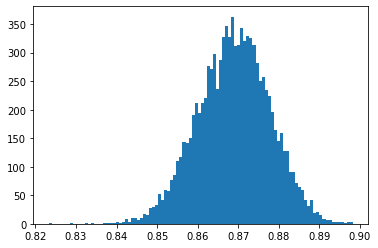

In [41]:
plt.hist(aucs, bins=100)
plt.show()

In [42]:
exp_var = np.std(aucs)**2

In [43]:
#Comparison:
print("Theoretical variance:", round(theoretical_var,7))
print("Bootstrap variance:", round(exp_var,7))

Theoretical variance: 7.21e-05
Bootstrap variance: 7.85e-05


## A practical example: finding backtest sample size

Assume we run backtests of a specific credit model with clients. 

We need to ask them for a dataset to prove our product's performance. The dataset must:
* not be too small (so we avoid small data issues)
* not be too big (complex, might have legal issues to share)

**What is an optimal range for the sample size?**

* Let us assume the population imbalance ratio is $\alpha < 1$ 

* Assume we want the ROC AUC to be precise to $\epsilon$, an absolute number such as 0.01 (ie. a variance of $10^{-4}$).

From the formula for a (random) classifier's AUC,

$$\sigma^2 \approx \frac{n_1+n_0}{{12 n_1 n_0}}$$

if we write $n_1 = \alpha N$, $n_0 = (1-\alpha) N$ we get

$$\sigma^2 = \frac{N}{12 N^2 \alpha(1-\alpha)} = \frac{1}{12 N \alpha(1-\alpha)}$$

Setting $\sigma \leq \epsilon$ we find $N$ to be

$$\boxed{N \geq \frac{1}{12 \epsilon^2 \alpha(1-\alpha)}}$$

**Example**: for $\alpha = 0.10$ and $\epsilon = 0.01$, we find

In [51]:
alpha = 0.10
epsilon = 0.01
print("Sample size:",int(1/(12*alpha*(1-alpha)*epsilon**2)))

Sample size: 9259


Thus, it is reasonable to ask clients for a dataset with around 10,000 points for a backtest if we want to report AUC to 1 percentage point error.

# The (beautiful & useless) extreme-imbalance, random classifier

Lett us get the simplest possible estimator: a random one, where all scores are uniformly sampled from $[0,1]$. In this context, how likely are we to get a spuriously large AUC?

In particular, we want to consider an **extreme imbalance scenario** where

1. $n$ is small (say, less than 100)

2. The ratio $n/N$ is small: $n/N \ll 1$ (say, 1% or less)

Our intuition tells us that this case should be more interesting than the big-data, balanced one: since one has only a few ($n$) points in class 1, if we are "lucky" to get high scores for all of them, the AUC will end up being high. 

We will use the AUC estimator as defined above:

$$\hat A = \frac{1}{n(N-n)} \sum_{i=1}^{n} \sum_{j=1}^{N-n} 1_{P_i \geq Q_j}$$

First, we have a trivial result: for all $i \in I$, $j \in J$, if $P_i, Q_j$ iid distributed as $\mathrm{Uniform}([0,1])$ then

$$1_{P_i \geq Q_j} | P_i \; \sim \;\mathrm{Bernoulli}(P_i)$$

Since a binomial variable is built from a sum of independent Bernoulli ones, we have a corollary: for all $i \in I$, 

$$\sum_{j \in J}\left. 1_{P_i \geq Q_j} \right| P_i \; \sim \; \mathrm{Binomial}(N-n, P_i)$$

Now, for large $N-n$, we may use the normal approximation to the binomial, namely a $\mathrm{Binomial}(n,p)$ variable converges to a $\mathcal N(\mu=np, \sigma^2 = np(1-p))$ variable as $n$ grows. Hence

$$\sum_{j \in J}\left. 1_{P_i \geq Q_j} \right| P_i \; \sim \; \mathcal N\left( (N-n)P_i,  (N-n)P_i (1-P_i) \right)$$

It follows that, for all $i\in I$,

$$Z_i |P_i := \frac{1}{N-n} \sum_{j \in J} \left.1_{P_i \geq Q_j}\right| \, P_i \;\sim \; \mathcal N \left(P_i, \frac{P_i (1-P_i)}{N-n}\right)$$

This defines a set of $n$ variables $Z_i$. To obtain their marginal distribution, notice that for any $Z_i$ its PDF is given by

$$p_{Z_i}(z) = \int p(z|P_i=p) p(P_i=p) dp;$$

but $P_i \; \sim \; \mathrm{Uniform}([0,1])$, and hence its PDF is just the identity on $[0,1]$. Letting

$$f(x|\mu,\sigma^2) \equiv \frac{1}{\sqrt{2\pi \sigma^2}} \exp\left\{ - \frac{(x-\mu)^2}{2\sigma^2} \right\}$$

be the Gaussian PDF, we obtain

$$p_{Z_i}(z) = \int_0^1 f \left(\left. z \frac{}{} \right|\, p, \frac{p(1-p)}{N-n} \right) dp$$

For $N-n$ large (as is our hypothesis), the integrand (as a function of $p$) is basically a very sharp peak centered at $p=z$. In fact, we may approximate it as a Dirac delta function

$$f\left(z \left. \frac{}{} \right|\, p, \frac{p(1-p)}{N-n} \right) \approx \delta(z-p)$$

to obtain

$$p_{Z_i}(z) = 1_{z \in [0,1]} \quad \Rightarrow \quad Z_i \; \sim \; \mathrm{Uniform}([0,1])$$

We have also tested this numerically - even for $n/N$ not that small this holds surprisingly well.

**If we assume all $Z_i$'s are independent among themselves**, the it means that $n \widehat{\mathrm{AUC}}$ is the sum of $n$ independent uniform variables: it follows the so-called Irwin-Hall distribution, and we have our most important result below.

Notice: we have not proven this independence assumption - it is **not obvious**, and we prove it below.

**Theorem**. Let $\widehat{\mathrm{AUC}}_\mathrm{random}$ denote the ROC AUC estimator for a *uniformly random scoring function*. Let there be $n$ instances of class 1 and $N-n$ instances of class 0, where $N\geq n$. Then

$$\boxed{n \widehat{\mathrm{AUC}}_\mathrm{random} \; \sim \; \mathrm{IrwinHall}(n)};$$

notice that this result **does not depend on $N$ explicitly**; we've only used that $N$ is large and also much larger than $n$.

As Wikipedia can tell us, if $A \sim \mathrm{IrwinHall}(n)$ then

$$\mathbb E[A] = \frac{n}{2};\qquad \mathrm{Var}(A) = \frac{n}{12};$$

for the AUC, this gives 

$$\boxed{\mathbb E[\widehat{\mathrm{AUC}}_\mathrm{random}] = \frac{1}{2};\qquad \mathrm{Var}[\widehat{\mathrm{AUC}}_\mathrm{random}] = \frac{1}{12 n}}$$

The first result is not surprising: we know that for a random scoring function the AUC should be 1/2. The second one is more surprising, and shows that as we increase $n$, we get an increasingly more precise AUC at 0.5 with a standard deviation that goes as $1/\sqrt{n}$.

We can now use this result to calculate how likely a statistical fluke is to happen: recall Chebyshev's inequality for any (square-integrable) random variable $X$:

$$\mathbb P(|X - \mu| \geq t) \leq \frac{\mathrm{Var} \, X}{t^2}$$

for our random AUC, this gives

$$\boxed{\mathbb P \left(\left|\, \widehat{\mathrm{AUC}}_\mathrm{random} - \frac 12 \right| \geq t \right) \leq \frac{1}{12 n t^2}}$$

**Examples**: 

In [45]:
n = 20
print(f"{n=}")
for t in [0.1, 0.2, 0.3, 0.4]:
    print(f"Probability of AUC > {0.5+t} is less than {round(100/(12*n*t**2), 2)}%")

n=20
Probability of AUC > 0.6 is less than 41.67%
Probability of AUC > 0.7 is less than 10.42%
Probability of AUC > 0.8 is less than 4.63%
Probability of AUC > 0.9 is less than 2.6%


## Proof that ROC AUC becomes the sum of scores for class 1 

Recall that, above, we defined $Z_i$ as
$$\hat A = \frac{1}{n(N-n)} \sum_{i=1}^{n} \sum_{j=1}^{N-n} 1_{P_i \geq Q_j} = \frac{1}{n} \sum_{i=1}^n Z_i$$

where
$$Z_i \equiv Z_i^{(N)} = \frac{1}{N-n} \sum_{j\in J} 1_{P_i \geq Q_j}$$

We have shown that as $N$ grows this variable becomes uniform. We can actually prove something stronger: that **$Z_i$ essentially becomes $P_i$ itself!**

The intuition here is that, as $N$ grows large, the $Q_j$'s basically cover the whole $[0,1]$ interval, and since $Z_i$ cares only about their aggregated values, it essencially becomes independent of them.

More precisely: let $Q_J \equiv \{Q_j: j \in J\}$ be a shorthand for all the scores in class 0. We will show three results:

* **Proposition 1:** $Z_i|Q_J$ converges on the mean to $P_i$, ie. 

  $$\lim_{N\to\infty} \mathbb E\left[\left.Z_i^{(N)} - P_i \;\right| Q_J\right] = 0$$
  
* **Corollary**: $Z_i|Q_J$ converges in probability to $P_i$, ie. 

  $$\lim_{N\to\infty} \mathbb P\left(\left.|Z_i^{(N)} - P_i| \geq a \;\right| Q_J\right) = 0,\qquad \forall a > 0$$
  
* **Proposition 2:** $Z_i|Q_J$ converges in the mean-squared sense to $P_i$, ie. 

  $$\boxed{\lim_{N\to\infty} \mathbb E\left[\left. \left(Z_i^{(N)} - P_i \right)^2\;\right| Q_J\right] = 0}$$

Since $P_i$ is independent of $Q_J$, this shows that the (conditional on $Q_J$) variable $Z_i$ converges to the (unconditional on $Q_J$) variable $P_i$. The problem is so unbalanced that the probabilities of the majority class are essentially "integrated out", and only the scores of the minority class remain.

In practice, this means that

$$\boxed{\widehat{\mathrm{AUC}} \approx \frac{1}{n} \sum_{i: y_i=1} P_i} \quad \mbox{(very high imbalance, random scoring)}$$

In what follows, we write $N-n \equiv M$ to unclutter notation.

**Proof of Proposition 1**: by direct evaluation, using that the variable $1_{P_i \geq Q_j}\,|Q_j$ is Bernoulli with parameter $1-Q_j$, we get

\begin{align*}
\mathbb E\left[\left.Z_i^{(N)} - P_i \;\right| Q_J\right] &= \frac{1}{M} \sum_j \mathbb E[1_{P_i \geq Q_j}\,|Q_j]- \mathbb E[P_i]\\
&=\frac 1M \sum_j (1-Q_j) - \frac 12\\
&= \frac 12 - \frac 1M \sum_{j\in J} Q_j
\end{align*}

As $M$ (thus $N$) grows larger, intuitively, the $Q_j$ cover $[0,1]$ and so the sum above becomes a Riemann sum. We get

\begin{align*}
\lim_{N\to\infty}\mathbb E\left[\left.Z_i^{(N)} - P_i \;\right| Q_J\right] &= \frac 12 - \int_0^1 q\, dq \\
&=\frac 12 - \frac 12\\
&= 0
\end{align*}

as we wanted to prove.

**Proof of Corollary**. Recall Markov's inequality: if $X$ is an integrable, non-negative random variable, then

$$\mathbb P(X \geq t) \leq \frac{\mathbb E[X]}{t}$$

Setting $X = (\left.Z_i^{(N)} - P_i )\;\right| Q_J$ and taking the limit gives the proof.

**Proof of Proposition 2**: we want to prove that 

$$\lim_{N\to\infty} \mathbb E\left[\left. \left(Z_i^{(N)} - P_i \right)^2\;\right| Q_J\right] = 0.$$

To do that, we compute the square

$$\mathbb E\left[\left. \left(Z_i^{(N)} - P_i \right)^2\;\right| Q_J\right] = \underbrace{\mathbb E\left[\left.(Z_i^{(N)})^2\,\right|Q_J\right]}_{(*)} - 2 \underbrace{\mathbb E\left[\left. P_i Z_i^{(N)} \,\right|Q_J\right]}_{(**)} + \underbrace{\mathbb E\left[\left.P_i^2\,\right|Q_J\right]}_{(***)}$$

We compute one term at a time. ${(***)}$ is the easiest: since $P_i \,\sim\,\mathrm{Uniform}([0,1])$ is independent of $Q_J$, this is just 

$$\mathbb E\left[\left.P_i^2\,\right|Q_J\right] = \frac 13$$

For $(**)$, we need to explicitly compute the expectation; then, taking the limit, we will find a Riemann sum. We have

\begin{align*}
\mathbb E\left[\left. P_i Z_i^{(N)} \,\right|Q_J\right] &= \frac 1M \sum_j \mathbb E\left[\left. P_i 1_{P_i \geq Q_j}\,\right|Q_j\right] \\
&= \frac 1M \sum_j \int_0^1 p 1_{p \geq Q_j} \, dp = \frac 1M \sum_j \int_{Q_j}^1 p\, dp \\
&= \frac 1M \sum_j \left( \frac{1-Q_j^2}{2}\right)\\
&\xrightarrow[N \to \infty]{} \int_0^1 \frac{1 - q^2}{2} dq\\
&= \frac 13
\end{align*}

Finally, for $(*)$, the procedure is technically more involved but basically identical:

\begin{align*}
\mathbb E\left[\left.(Z_i^{(N)})^2\,\right|Q_J\right] &= \mathbb E \left[\left. \frac{1}{M^2} \sum_{j \in J} \sum_{k\in J} 1_{P_i \geq Q_j} 1_{P_i \geq Q_k} \;\right|Q_J\right]\\
&=\frac{1}{M^2}  \mathbb E \left[\left.\sum_{j \in J}  1_{P_i \geq Q_j} + 2 \sum_j \sum_{k < j} 1_{P_i \geq Q_j} 1_{P_i \geq Q_k} \;\right|Q_J\right]\\
\end{align*}

With no loss of generality, order the $Q_j$'s in an ascending order, so that $Q_j \geq Q_k$ if $j > k$. We can then simplify the second sum by considering that $P_i$ must be larger than $\max(Q_j, Q_k) = Q_j$. Hence

\begin{align*}
\mathbb E\left[\left.(Z_i^{(N)})^2\,\right|Q_J\right] &= \frac{1}{M^2}\left\{
    \sum_j \mathbb E\left[\left.1_{P_i \geq Q_j}\,\right|Q_j\right] +
    2 \sum_j \sum_{k < j} \mathbb E\left[\left.1_{P_i \geq Q_j}\,\right|Q_j\right]
    \right\}\\
&= \frac{1}{M^2}\left\{\sum_j (1-Q_j) + 2 \sum_j \sum_{k < j} (1-Q_j)\right\}\\
&= \frac{1}{M} \left[\frac{1}{M}\sum_j (1-Q_j)\right] + \frac{2}{M^2} \sum_j \sum_{k < j} (1-Q_j)
\end{align*}

Upon taking the limit, the first term will be killed by the excess $1/M$ term in front; the second one becomes the double sum

\begin{align*}
\mathbb E\left[\left.(Z_i^{(N)})^2\,\right|Q_J\right] &\xrightarrow[N \to \infty]{} 0 + 2 \int_0^1 dq \int_0^q dx \, (1-q)\\
&= 2 \int_0^1 dq \, q(1-q)\\
&= \frac 13.
\end{align*}

Hence, putting all results $(*)$ to $(***)$ together, we get

$$\lim_{N\to\infty} \mathbb E\left[\left. \left(Z_i^{(N)} - P_i \right)^2\;\right| Q_J\right] = \frac 13 - 2 \cdot \frac 13 + \frac 13 = 0$$

This proves Proposition 2.

## Simulating this result

Below, we test

$$\widehat{\mathrm{AUC}} \approx \frac{1}{n} \sum_{i: y_i=1} P_i \quad \mbox{(very high imbalance, random scoring)}$$

basically by creating a highly imbalanced dataset with only 15 points of class 1, and comparing the ROC AUC calculation with the average of the scores predicted for class 1.

In [46]:
from sklearn.metrics import roc_auc_score, roc_curve

In [47]:
def fixed_imbalanced_dataset(total_samples=20000, 
                            class_1_samples=15):
    import pandas as pd
    from sklearn.datasets import make_classification
    
    X, y = make_classification(n_samples=total_samples,
                               weights=(0.8,),
                               random_state=4)

    df = pd.DataFrame(X)
    df['y'] = y
    df0 = df[df['y']==0]
    df1 = df[df['y']==1]

    df1_red = df1.sample(n=class_1_samples)

    df_new = pd.concat([df1_red, df0]).sample(frac=1)
    X, y = df_new.drop('y', axis=1).values, df_new['y'].values
    
    return X, y

In [48]:
X, y = fixed_imbalanced_dataset()

In [49]:
np.bincount(y)

array([15947,    15])

In [50]:
# create random prediction
for i, seed in enumerate([12,51,25,62]):
    np.random.seed(seed)
    y_pred = np.random.rand(*y.shape)
    
    roc_auc = roc_auc_score(y, y_pred)
    mean_prediction = y_pred[y==1].mean()
    print(f"Trial {i+1}:")
    print(f"  - ROC AUC           : {round(roc_auc,3)}")
    print(f"  - Mean score class 1: {round(mean_prediction,3)}")

Trial 1:
  - ROC AUC           : 0.594
  - Mean score class 1: 0.593
Trial 2:
  - ROC AUC           : 0.557
  - Mean score class 1: 0.558
Trial 3:
  - ROC AUC           : 0.549
  - Mean score class 1: 0.551
Trial 4:
  - ROC AUC           : 0.457
  - Mean score class 1: 0.456


## References

[1] Cortes, Corinna and Mohri, Mehryar, *Confidence Intervals for the Area Under the ROC Curve*. Advances in Neural Information Processing Systems, 17 (2004).
Available at https://proceedings.neurips.cc/paper/2004/file/a7789ef88d599b8df86bbee632b2994d-Paper.pdf

[2] S. Shirahata, *Estimate of variance of Wilcoxon-Mann-Whitney statistic.* J. Japanese Soc. Comp. Statist. 6.2(1993), 1-10. Available at: https://www.jstage.jst.go.jp/article/jjscs1988/6/2/6_2_1/_pdf/-char/en
